# Simulation using Concord

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
proj_name = "simulation_clustereasy_singlebatch"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = f"../data/{proj_name}/"
data_dir = Path(data_dir)
data_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 0
ccd.ul.set_seed(seed)

file_suffix = f"{time.strftime('%b%d-%H%M')}"
file_suffix

cpu


'Jul14-1916'

In [4]:
state_key = 'cluster'
batch_key = 'batch'
state_type = 'cluster'
leiden_key='leiden'
batch_type = 'batch_specific_features'
distribution = 'normal'
n_cells = [100,100,50]
n_genes = [100,100,50]
state_dispersion = [4.0,2.0,2.0]

In [5]:
from concord.simulation import (
    SimConfig, ClusterConfig, BatchConfig, Simulation
)

# ──────────────── Inputs ────────────────
seed = 42
n_cells = [100, 100, 50]
n_genes = [100, 100, 50]
state_dispersion = [4.0, 2.0, 2.0]

# ─────────────── SimConfig ───────────────
sim_cfg = SimConfig(
    n_cells=n_cells,
    n_genes=n_genes,
    seed=seed,
    non_neg=True,
    to_int=True,
)

# ─────────────── ClusterConfig ───────────────
state_cfg = ClusterConfig(
    n_states=3,
    distribution="normal",
    level=5.0,
    min_level=0.0,
    dispersion=state_dispersion,
    program_structure="uniform",
    program_on_time_fraction=0.3,
    global_non_specific_gene_fraction=0.1,
    pairwise_non_specific_gene_fraction=None,
)

# ─────────────── BatchConfig ───────────────
batch_cfg = BatchConfig(
    n_batches=1,
    effect_type="batch_specific_features",
    distribution="normal",
    level=[5.0],              # One value for 1 batch
    dispersion=[3.0],
    feature_frac=0.15,
)

# ─────────────── Simulation ───────────────
sim = Simulation(sim_cfg, state_cfg, batch_cfg)
adata, adata_state = sim.simulate_data()
adata.layers["counts"] = adata.X.copy()


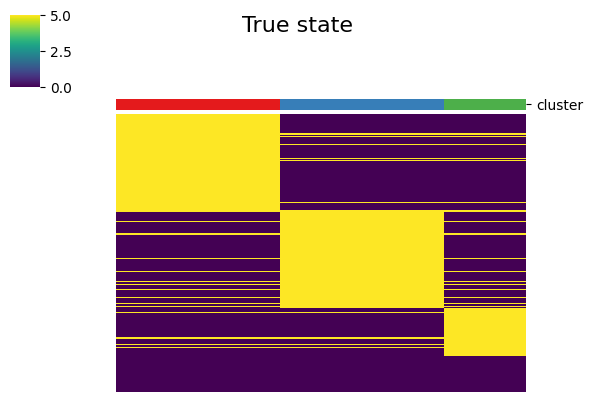

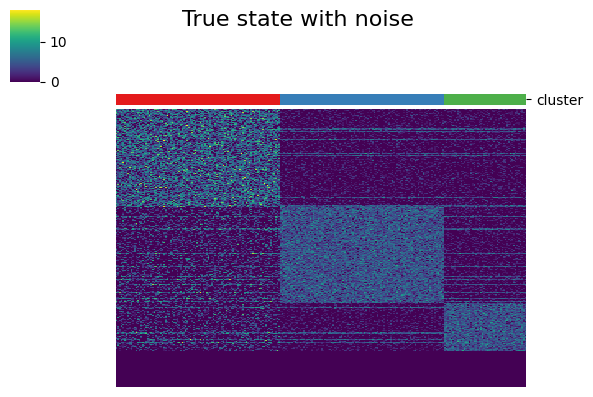

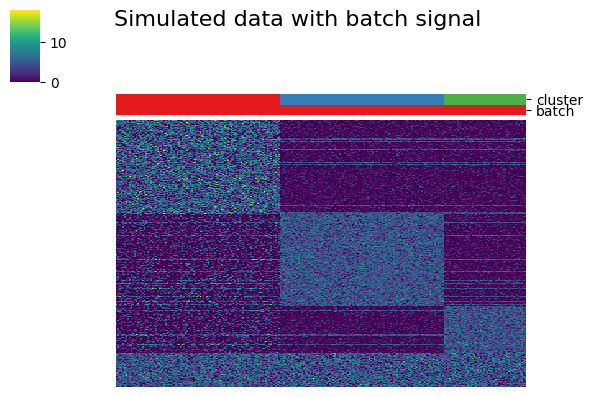

In [6]:
ccd.pl.heatmap_with_annotations(adata, val='no_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state', save_path=save_dir/f'true_state_heatmap_{file_suffix}.svg', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata, val='wt_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state with noise', save_path=save_dir/f'true_state_with_noise_heatmap_{file_suffix}.svg', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, batch_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Simulated data with batch signal', save_path=save_dir/f'simulated_data_heatmap_{file_suffix}.svg', figsize=(6, 4), dpi=300)

In [7]:
adata.shape

(250, 287)

### No batch effect, no noise

In [8]:
n_components = 15
ccd.ul.run_pca(adata, source_key='no_noise', result_key='PCA_no_noise', n_pc=n_components, random_state=seed)
ccd.ul.run_umap(adata, source_key='no_noise', result_key='UMAP_no_noise', random_state=seed)
sc.pp.neighbors(adata, use_rep='PCA_no_noise', n_neighbors=30, random_state=seed)
sc.tl.leiden(adata, resolution=1.0, key_added=leiden_key, random_state=seed)
#adata.obs[leiden_key] = adata_state.obs[leiden_key]

concord - INFO - PCA performed on source data with 15 components
concord - INFO - PCA embedding stored in adata.obsm['PCA_no_noise']


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


concord - INFO - UMAP embedding stored in adata.obsm['UMAP_no_noise']


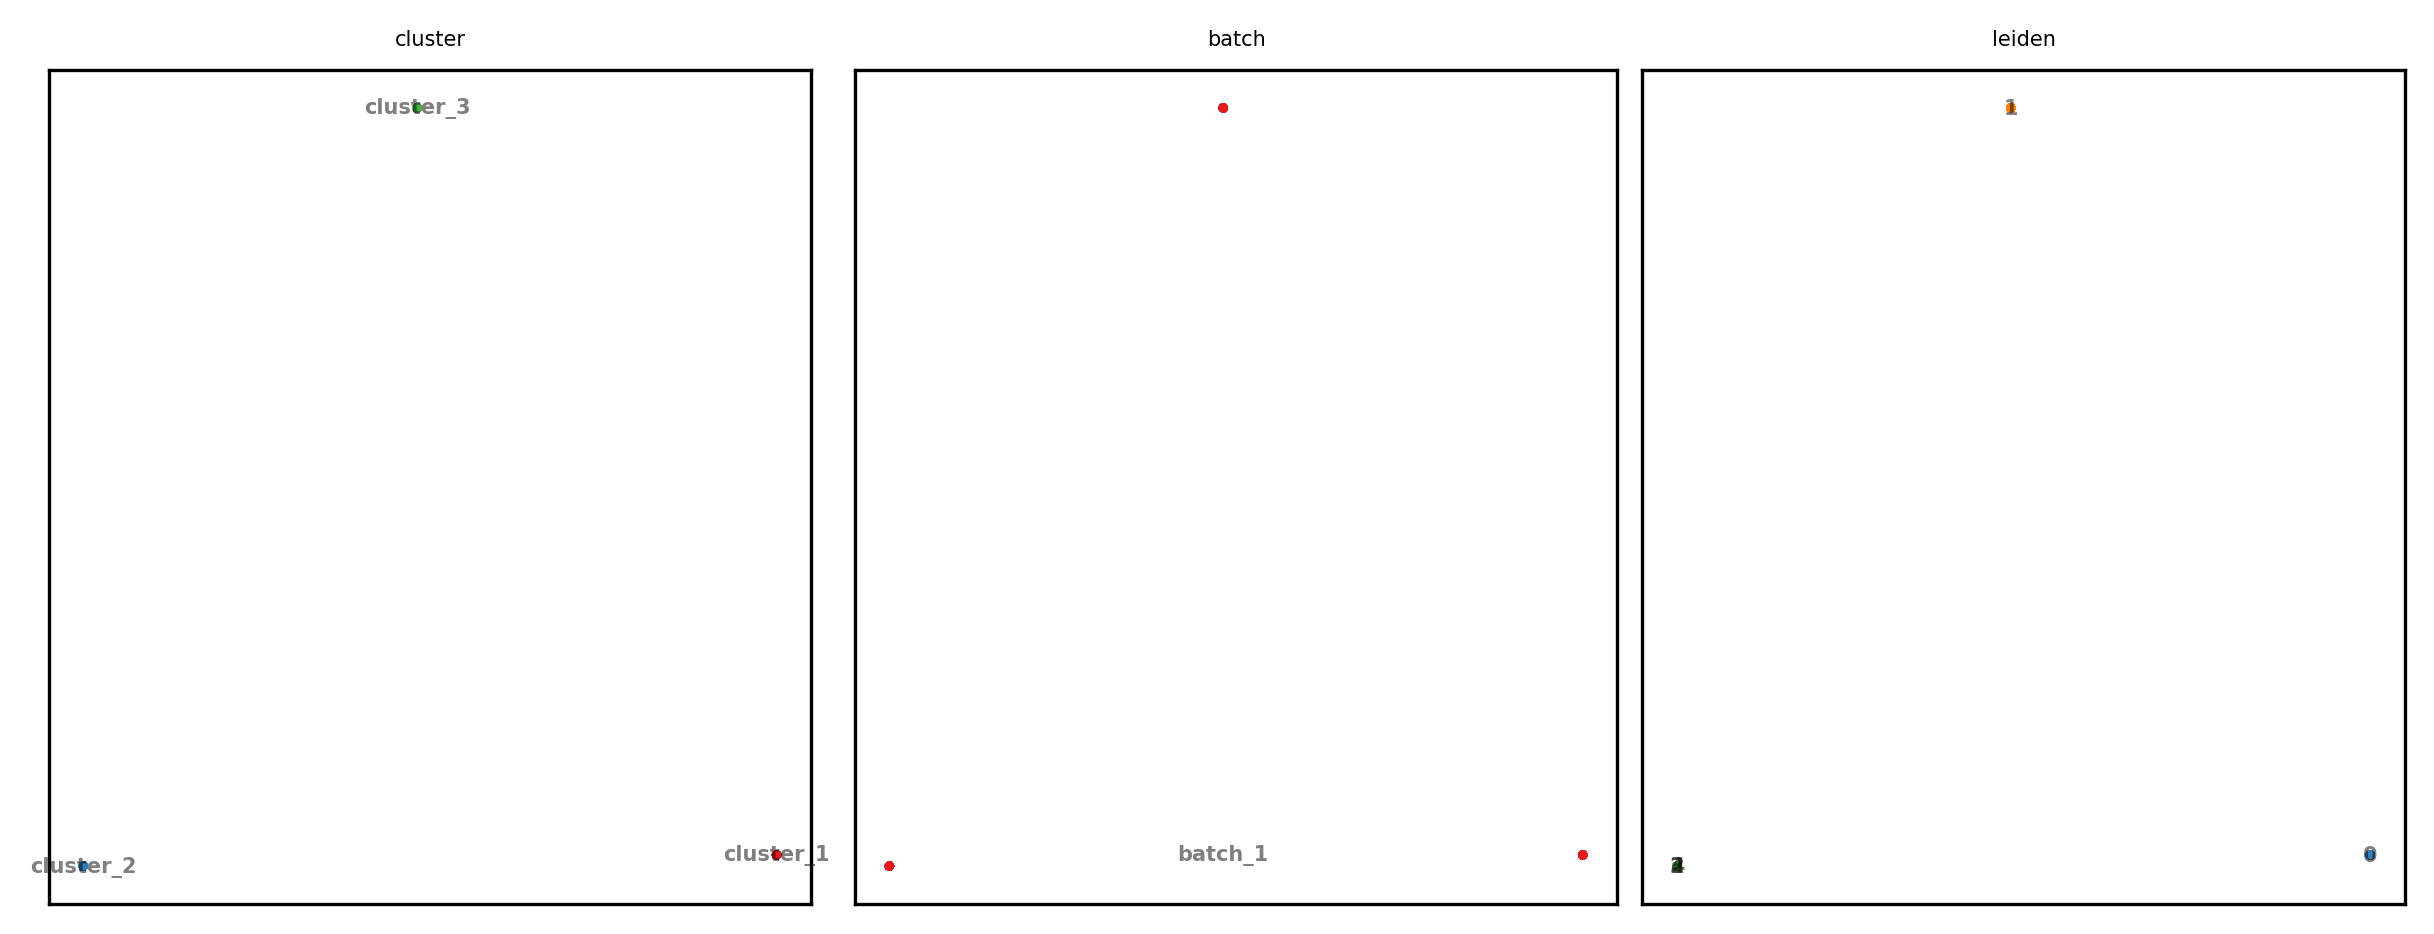

In [9]:
show_basis = 'PCA_no_noise'
show_cols = [state_key, batch_key, leiden_key]

ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"nobatch_{show_basis}_{file_suffix}.svg"
)

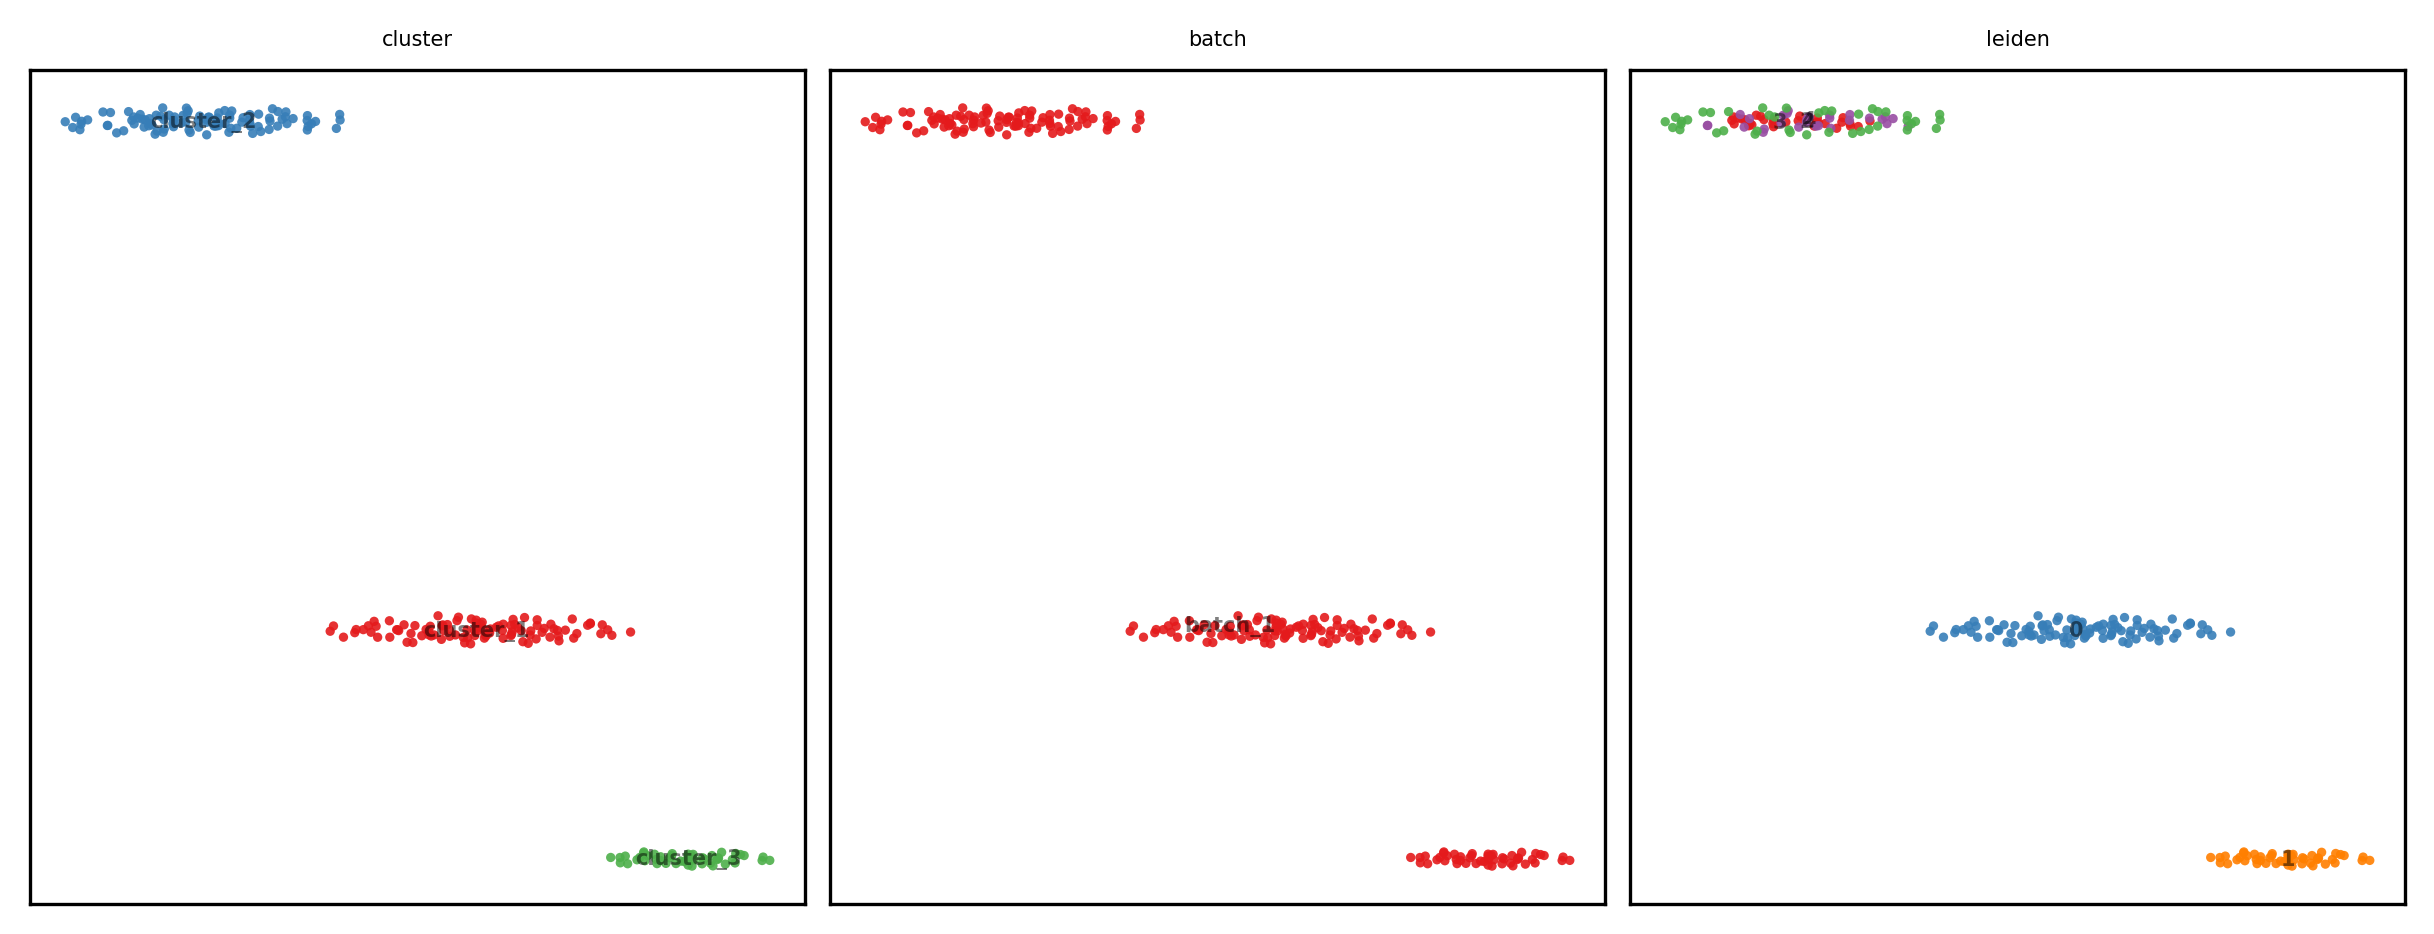

In [10]:
show_basis = 'UMAP_no_noise'

ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"nobatch_{show_basis}_{file_suffix}.svg"
)

### noise added, Run all methods

In [21]:
run_methods = ["PCA", "UMAP", "t-SNE", "DiffusionMap", "NMF", 
             "FactorAnalysis", "FastICA", "LDA", "ZIFA", "scVI", "PHATE", 
             "contrastive", "concord_hcl", "concord_knn", ]
# exclude ["UMAP", "t-SNE"] from run_method, and save as combined_keys
exclude_keys = ["PCA", "UMAP", "t-SNE"]
combined_keys = ['no_noise', 'wt_noise'] + [key for key in run_methods if key not in exclude_keys]
combined_keys

['no_noise',
 'wt_noise',
 'DiffusionMap',
 'NMF',
 'FactorAnalysis',
 'FastICA',
 'LDA',
 'ZIFA',
 'scVI',
 'PHATE',
 'contrastive',
 'concord_hcl',
 'concord_knn']

In [22]:
run_methods

['PCA',
 'UMAP',
 't-SNE',
 'DiffusionMap',
 'NMF',
 'FactorAnalysis',
 'FastICA',
 'LDA',
 'ZIFA',
 'scVI',
 'PHATE',
 'contrastive',
 'concord_hcl',
 'concord_knn']

In [23]:
concord_kwargs = {
    'load_data_into_memory': True,
    'verbose': True,
}
bench_res = ccd.bm.run_dimensionality_reduction_pipeline(
    adata,
    source_key="X",
    methods=run_methods,
    n_components=15,
    seed=seed,
    device=device,
    save_dir=save_dir,
    concord_kwargs=concord_kwargs,
)

concord - INFO - PCA performed on source data with 15 components
concord - INFO - PCA embedding stored in adata.obsm['PCA']
concord.benchmarking.benchmark - INFO - PCA: 0.00s | 0.17 MB RAM | 0.00 MB VRAM
concord - INFO - UMAP embedding stored in adata.obsm['UMAP']
concord.benchmarking.benchmark - INFO - UMAP: 0.22s | 0.00 MB RAM | 0.00 MB VRAM
concord - INFO - T-SNE embedding stored in adata.obsm['tSNE']
concord.benchmarking.benchmark - INFO - t-SNE: 0.78s | 3.05 MB RAM | 0.00 MB VRAM
concord.benchmarking.benchmark - INFO - DiffusionMap: 0.02s | 0.00 MB RAM | 0.00 MB VRAM
concord.benchmarking.benchmark - INFO - NMF: 0.07s | 0.00 MB RAM | 0.00 MB VRAM
concord.benchmarking.benchmark - INFO - FactorAnalysis: 0.01s | 0.00 MB RAM | 0.00 MB VRAM
concord.benchmarking.benchmark - INFO - FastICA: 0.02s | 0.02 MB RAM | 0.00 MB VRAM
concord.benchmarking.benchmark - INFO - LDA: 0.98s | 0.00 MB RAM | 0.00 MB VRAM
Running zero-inflated factor analysis with N = 250, D = 287, K = 15
Param change below

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


concord.benchmarking.benchmark - INFO - scVI: 3.90s | 0.08 MB RAM | 0.00 MB VRAM
Calculating PHATE...
  Running PHATE on 250 observations and 287 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.02 seconds.
    Calculating KNN search...
    Calculating affinities...
    Calculated affinities in 0.05 seconds.
  Calculated graph and diffusion operator in 0.09 seconds.
  Calculating optimal t...
    Automatically selected t = 8
  Calculated optimal t in 0.01 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.02 seconds.
Calculated PHATE in 0.13 seconds.
concord.benchmarking.benchmark - INFO - PHATE: 0.13s | 0.02 MB RAM | 0.00 MB VRAM
Running concord_knn with config: {'mode': 'default', 'extra_kwargs': {'p_intra_knn': 0.3, 'clr_beta': 0.0}}
concord - INFO - Operating directly on the provided AnnData object. Object may be modified.
concord - WARNING - save_dir is None. Model and log fi

Epoch 0 Training: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it, loss=5.790]

concord - INFO - Epoch   0 | Train Loss: 5.79, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.79, IMPORTANCE: 0.00
concord - INFO - Starting epoch 2/15
concord - INFO - Processing chunk 1/1 for epoch 2
concord - INFO - Number of samples in train_dataloader: 250



Epoch 1 Training: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, loss=5.689]

concord - INFO - Epoch   1 | Train Loss: 5.69, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.69, IMPORTANCE: 0.00
concord - INFO - Starting epoch 3/15
concord - INFO - Warm-up complete. Computing k-NN graph on learned embeddings.
concord.model.dataloader - INFO - Using 1 DataLoader workers.
concord.model.anndataset - INFO - Initialized lightweight dataset with 250 samples.
concord.model.dataloader - INFO - Loading all data into memory for fast access. This may consume a lot of RAM. If you run out of memory, please set `load_data_into_memory=False`.
concord - INFO - Predicting for chunk 1/1


concord.model.dataloader - INFO - Using 1 DataLoader workers.
concord.model.anndataset - INFO - Initialized lightweight dataset with 250 samples.
concord.model.dataloader - INFO - Loading all data into memory for fast access. This may consume a lot of RAM. If you run out of memory, please set `load_data_into_memory=False`.
concord.model.dataloader - INFO - Computing k-NN graph using embedding from 'X_concord_warmup'...
concord - INFO - Using euclidean distance metric.
concord - WARNING - FAISS not found. Using sklearn for k-NN computation.
concord - INFO - Processing chunk 1/1 for epoch 3
concord - INFO - Number of samples in train_dataloader: 250


Epoch 2 Training: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, loss=5.865]

concord - INFO - Epoch   2 | Train Loss: 5.87, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.87, IMPORTANCE: 0.00
concord - INFO - Starting epoch 4/15
concord - INFO - Processing chunk 1/1 for epoch 4
concord - INFO - Number of samples in train_dataloader: 250



Epoch 3 Training: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, loss=5.881]

concord - INFO - Epoch   3 | Train Loss: 5.88, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.88, IMPORTANCE: 0.00
concord - INFO - Starting epoch 5/15
concord - INFO - Processing chunk 1/1 for epoch 5
concord - INFO - Number of samples in train_dataloader: 250



Epoch 4 Training: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, loss=5.833]

concord - INFO - Epoch   4 | Train Loss: 5.83, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.83, IMPORTANCE: 0.00
concord - INFO - Starting epoch 6/15
concord - INFO - Processing chunk 1/1 for epoch 6
concord - INFO - Number of samples in train_dataloader: 250



Epoch 5 Training: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it, loss=5.756]

concord - INFO - Epoch   5 | Train Loss: 5.76, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.76, IMPORTANCE: 0.00
concord - INFO - Starting epoch 7/15
concord - INFO - Processing chunk 1/1 for epoch 7
concord - INFO - Number of samples in train_dataloader: 250



Epoch 6 Training: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, loss=5.678]

concord - INFO - Epoch   6 | Train Loss: 5.68, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.68, IMPORTANCE: 0.00
concord - INFO - Starting epoch 8/15
concord - INFO - Processing chunk 1/1 for epoch 8
concord - INFO - Number of samples in train_dataloader: 250



Epoch 7 Training: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, loss=5.627]

concord - INFO - Epoch   7 | Train Loss: 5.63, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.63, IMPORTANCE: 0.00
concord - INFO - Starting epoch 9/15
concord - INFO - Processing chunk 1/1 for epoch 9
concord - INFO - Number of samples in train_dataloader: 250



Epoch 8 Training: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, loss=5.516]

concord - INFO - Epoch   8 | Train Loss: 5.52, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.52, IMPORTANCE: 0.00
concord - INFO - Starting epoch 10/15
concord - INFO - Processing chunk 1/1 for epoch 10
concord - INFO - Number of samples in train_dataloader: 250



Epoch 9 Training: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, loss=5.487]

concord - INFO - Epoch   9 | Train Loss: 5.49, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.49, IMPORTANCE: 0.00
concord - INFO - Starting epoch 11/15
concord - INFO - Processing chunk 1/1 for epoch 11
concord - INFO - Number of samples in train_dataloader: 250



Epoch 10 Training: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, loss=5.433]

concord - INFO - Epoch  10 | Train Loss: 5.43, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.43, IMPORTANCE: 0.00
concord - INFO - Starting epoch 12/15
concord - INFO - Processing chunk 1/1 for epoch 12
concord - INFO - Number of samples in train_dataloader: 250



Epoch 11 Training: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, loss=5.342]

concord - INFO - Epoch  11 | Train Loss: 5.34, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.34, IMPORTANCE: 0.00
concord - INFO - Starting epoch 13/15
concord - INFO - Processing chunk 1/1 for epoch 13
concord - INFO - Number of samples in train_dataloader: 250



Epoch 12 Training: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, loss=5.344]

concord - INFO - Epoch  12 | Train Loss: 5.34, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.34, IMPORTANCE: 0.00
concord - INFO - Starting epoch 14/15
concord - INFO - Processing chunk 1/1 for epoch 14
concord - INFO - Number of samples in train_dataloader: 250



Epoch 13 Training: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, loss=5.318]

concord - INFO - Epoch  13 | Train Loss: 5.32, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.32, IMPORTANCE: 0.00
concord - INFO - Starting epoch 15/15
concord - INFO - Processing chunk 1/1 for epoch 15
concord - INFO - Number of samples in train_dataloader: 250



Epoch 14 Training: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it, loss=5.268]

concord - INFO - Epoch  14 | Train Loss: 5.27, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.27, IMPORTANCE: 0.00
concord - WARNING - save_dir is None. Skipping model/config saving.
concord.model.dataloader - INFO - Using 1 DataLoader workers.
concord.model.anndataset - INFO - Initialized lightweight dataset with 250 samples.
concord.model.dataloader - INFO - Loading all data into memory for fast access. This may consume a lot of RAM. If you run out of memory, please set `load_data_into_memory=False`.
concord - INFO - Predicting for chunk 1/1


concord - INFO - Predictions added to AnnData object with base key 'concord_knn'.
concord.benchmarking.benchmark - INFO - concord_knn: 39.29s | 0.31 MB RAM | 0.00 MB VRAM
Running concord_hcl with config: {'mode': 'default', 'extra_kwargs': {'p_intra_knn': 0.0, 'clr_beta': 1.0}}
concord - INFO - Operating directly on the provided AnnData object. Object may be modified.
concord - WARNING - save_dir is None. Model and log files will not be saved.
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - INFO - Using NT-Xent loss with beta=1.0. This will apply hard-negative weighting to the contrastive loss.
concord - INFO - HCL (Contrastive learning with hard negative samples) mode is enabled.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
concord - INFO - Pr

Epoch 0 Training: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it, loss=5.950]

concord - INFO - Epoch   0 | Train Loss: 5.95, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.95, IMPORTANCE: 0.00
concord - INFO - Starting epoch 2/15
concord - INFO - Processing chunk 1/1 for epoch 2
concord - INFO - Number of samples in train_dataloader: 250



Epoch 1 Training: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it, loss=5.698]

concord - INFO - Epoch   1 | Train Loss: 5.70, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.70, IMPORTANCE: 0.00
concord - INFO - Starting epoch 3/15
concord - INFO - Processing chunk 1/1 for epoch 3
concord - INFO - Number of samples in train_dataloader: 250



Epoch 2 Training: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, loss=5.767]

concord - INFO - Epoch   2 | Train Loss: 5.77, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.77, IMPORTANCE: 0.00
concord - INFO - Starting epoch 4/15
concord - INFO - Processing chunk 1/1 for epoch 4
concord - INFO - Number of samples in train_dataloader: 250



Epoch 3 Training: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it, loss=5.729]

concord - INFO - Epoch   3 | Train Loss: 5.73, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.73, IMPORTANCE: 0.00
concord - INFO - Starting epoch 5/15
concord - INFO - Processing chunk 1/1 for epoch 5
concord - INFO - Number of samples in train_dataloader: 250



Epoch 4 Training: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it, loss=5.689]

concord - INFO - Epoch   4 | Train Loss: 5.69, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.69, IMPORTANCE: 0.00
concord - INFO - Starting epoch 6/15
concord - INFO - Processing chunk 1/1 for epoch 6
concord - INFO - Number of samples in train_dataloader: 250



Epoch 5 Training: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, loss=5.658]

concord - INFO - Epoch   5 | Train Loss: 5.66, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.66, IMPORTANCE: 0.00
concord - INFO - Starting epoch 7/15
concord - INFO - Processing chunk 1/1 for epoch 7
concord - INFO - Number of samples in train_dataloader: 250



Epoch 6 Training: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it, loss=5.702]

concord - INFO - Epoch   6 | Train Loss: 5.70, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.70, IMPORTANCE: 0.00
concord - INFO - Starting epoch 8/15
concord - INFO - Processing chunk 1/1 for epoch 8
concord - INFO - Number of samples in train_dataloader: 250



Epoch 7 Training: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it, loss=5.621]

concord - INFO - Epoch   7 | Train Loss: 5.62, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.62, IMPORTANCE: 0.00
concord - INFO - Starting epoch 9/15
concord - INFO - Processing chunk 1/1 for epoch 9
concord - INFO - Number of samples in train_dataloader: 250



Epoch 8 Training: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, loss=5.564]

concord - INFO - Epoch   8 | Train Loss: 5.56, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.56, IMPORTANCE: 0.00
concord - INFO - Starting epoch 10/15
concord - INFO - Processing chunk 1/1 for epoch 10
concord - INFO - Number of samples in train_dataloader: 250



Epoch 9 Training: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it, loss=5.545]

concord - INFO - Epoch   9 | Train Loss: 5.54, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.54, IMPORTANCE: 0.00
concord - INFO - Starting epoch 11/15
concord - INFO - Processing chunk 1/1 for epoch 11
concord - INFO - Number of samples in train_dataloader: 250



Epoch 10 Training: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it, loss=5.571]

concord - INFO - Epoch  10 | Train Loss: 5.57, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.57, IMPORTANCE: 0.00
concord - INFO - Starting epoch 12/15
concord - INFO - Processing chunk 1/1 for epoch 12
concord - INFO - Number of samples in train_dataloader: 250



Epoch 11 Training: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, loss=5.600]

concord - INFO - Epoch  11 | Train Loss: 5.60, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.60, IMPORTANCE: 0.00
concord - INFO - Starting epoch 13/15
concord - INFO - Processing chunk 1/1 for epoch 13
concord - INFO - Number of samples in train_dataloader: 250



Epoch 12 Training: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it, loss=5.572]

concord - INFO - Epoch  12 | Train Loss: 5.57, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.57, IMPORTANCE: 0.00
concord - INFO - Starting epoch 14/15
concord - INFO - Processing chunk 1/1 for epoch 14
concord - INFO - Number of samples in train_dataloader: 250



Epoch 13 Training: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it, loss=5.552]

concord - INFO - Epoch  13 | Train Loss: 5.55, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.55, IMPORTANCE: 0.00
concord - INFO - Starting epoch 15/15
concord - INFO - Processing chunk 1/1 for epoch 15
concord - INFO - Number of samples in train_dataloader: 250



Epoch 14 Training: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it, loss=5.518]

concord - INFO - Epoch  14 | Train Loss: 5.52, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.52, IMPORTANCE: 0.00
concord - WARNING - save_dir is None. Skipping model/config saving.
concord.model.dataloader - INFO - Using 1 DataLoader workers.
concord.model.anndataset - INFO - Initialized lightweight dataset with 250 samples.
concord.model.dataloader - INFO - Loading all data into memory for fast access. This may consume a lot of RAM. If you run out of memory, please set `load_data_into_memory=False`.
concord - INFO - Predicting for chunk 1/1


concord - INFO - Predictions added to AnnData object with base key 'concord_hcl'.
concord.benchmarking.benchmark - INFO - concord_hcl: 37.63s | 0.45 MB RAM | 0.00 MB VRAM
Skipping concord_class as it is not in the methods list.
Skipping concord_decoder as it is not in the methods list.
Running contrastive with config: {'mode': 'naive', 'extra_kwargs': {'p_intra_knn': 0.0, 'clr_beta': 0.0}}
concord - INFO - Operating directly on the provided AnnData object. Object may be modified.
concord - WARNING - save_dir is None. Model and log files will not be saved.
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
concord - INFO - Proceeding with all 287 features in the dataset.
concord - WARNING - domain/batch informatio

Epoch 0 Training: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it, loss=5.790]

concord - INFO - Epoch   0 | Train Loss: 5.79, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.79, IMPORTANCE: 0.00
concord - INFO - Starting epoch 2/15
concord - INFO - Processing chunk 1/1 for epoch 2
concord - INFO - Number of samples in train_dataloader: 250



Epoch 1 Training: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, loss=5.689]

concord - INFO - Epoch   1 | Train Loss: 5.69, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.69, IMPORTANCE: 0.00
concord - INFO - Starting epoch 3/15
concord - INFO - Processing chunk 1/1 for epoch 3
concord - INFO - Number of samples in train_dataloader: 250



Epoch 2 Training: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, loss=5.750]

concord - INFO - Epoch   2 | Train Loss: 5.75, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.75, IMPORTANCE: 0.00
concord - INFO - Starting epoch 4/15
concord - INFO - Processing chunk 1/1 for epoch 4
concord - INFO - Number of samples in train_dataloader: 250



Epoch 3 Training: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, loss=5.710]

concord - INFO - Epoch   3 | Train Loss: 5.71, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.71, IMPORTANCE: 0.00
concord - INFO - Starting epoch 5/15
concord - INFO - Processing chunk 1/1 for epoch 5
concord - INFO - Number of samples in train_dataloader: 250



Epoch 4 Training: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, loss=5.652]

concord - INFO - Epoch   4 | Train Loss: 5.65, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.65, IMPORTANCE: 0.00
concord - INFO - Starting epoch 6/15
concord - INFO - Processing chunk 1/1 for epoch 6
concord - INFO - Number of samples in train_dataloader: 250



Epoch 5 Training: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, loss=5.599]

concord - INFO - Epoch   5 | Train Loss: 5.60, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.60, IMPORTANCE: 0.00
concord - INFO - Starting epoch 7/15
concord - INFO - Processing chunk 1/1 for epoch 7
concord - INFO - Number of samples in train_dataloader: 250



Epoch 6 Training: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, loss=5.608]

concord - INFO - Epoch   6 | Train Loss: 5.61, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.61, IMPORTANCE: 0.00
concord - INFO - Starting epoch 8/15
concord - INFO - Processing chunk 1/1 for epoch 8
concord - INFO - Number of samples in train_dataloader: 250



Epoch 7 Training: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, loss=5.463]

concord - INFO - Epoch   7 | Train Loss: 5.46, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.46, IMPORTANCE: 0.00
concord - INFO - Starting epoch 9/15
concord - INFO - Processing chunk 1/1 for epoch 9
concord - INFO - Number of samples in train_dataloader: 250



Epoch 8 Training: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it, loss=5.373]

concord - INFO - Epoch   8 | Train Loss: 5.37, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.37, IMPORTANCE: 0.00
concord - INFO - Starting epoch 10/15
concord - INFO - Processing chunk 1/1 for epoch 10
concord - INFO - Number of samples in train_dataloader: 250



Epoch 9 Training: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, loss=5.266]

concord - INFO - Epoch   9 | Train Loss: 5.27, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.27, IMPORTANCE: 0.00
concord - INFO - Starting epoch 11/15
concord - INFO - Processing chunk 1/1 for epoch 11
concord - INFO - Number of samples in train_dataloader: 250



Epoch 10 Training: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, loss=5.264]

concord - INFO - Epoch  10 | Train Loss: 5.26, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.26, IMPORTANCE: 0.00
concord - INFO - Starting epoch 12/15
concord - INFO - Processing chunk 1/1 for epoch 12
concord - INFO - Number of samples in train_dataloader: 250



Epoch 11 Training: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it, loss=5.261]

concord - INFO - Epoch  11 | Train Loss: 5.26, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.26, IMPORTANCE: 0.00
concord - INFO - Starting epoch 13/15
concord - INFO - Processing chunk 1/1 for epoch 13
concord - INFO - Number of samples in train_dataloader: 250



Epoch 12 Training: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it, loss=5.190]

concord - INFO - Epoch  12 | Train Loss: 5.19, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.19, IMPORTANCE: 0.00
concord - INFO - Starting epoch 14/15
concord - INFO - Processing chunk 1/1 for epoch 14
concord - INFO - Number of samples in train_dataloader: 250



Epoch 13 Training: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, loss=5.162]

concord - INFO - Epoch  13 | Train Loss: 5.16, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.16, IMPORTANCE: 0.00
concord - INFO - Starting epoch 15/15
concord - INFO - Processing chunk 1/1 for epoch 15
concord - INFO - Number of samples in train_dataloader: 250



Epoch 14 Training: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, loss=5.116]

concord - INFO - Epoch  14 | Train Loss: 5.12, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.12, IMPORTANCE: 0.00
concord - WARNING - save_dir is None. Skipping model/config saving.
concord.model.dataloader - INFO - Using 1 DataLoader workers.
concord.model.anndataset - INFO - Initialized lightweight dataset with 250 samples.
concord.model.dataloader - INFO - Loading all data into memory for fast access. This may consume a lot of RAM. If you run out of memory, please set `load_data_into_memory=False`.
concord - INFO - Predicting for chunk 1/1


concord - INFO - Predictions added to AnnData object with base key 'contrastive'.
concord.benchmarking.benchmark - INFO - contrastive: 37.33s | 0.06 MB RAM | 0.00 MB VRAM
concord.benchmarking.benchmark - INFO - 📝 Time log saved to ../save/dev_simulation_clustereasy_singlebatch-Jul14/dimensionality_reduction_timelog.json


In [24]:
# Run umap and PCA for all latent embeddings
adata.obsm['no_noise'] = adata.layers['no_noise']
adata.obsm['wt_noise'] = adata.layers['wt_noise']
max_pc = 15
for basis in combined_keys:
    print("Running UMAP and PCA for", basis)
    #if 'UMAP' not in basis:
    ccd.ul.run_umap(adata, source_key=basis, result_key=f'{basis}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)
    if not any(substring in basis for substring in ['PHATE', 'PCA']):
        if basis in adata.layers.keys():
            n_pc = min(min(adata.layers[basis].shape[1], adata.shape[0]) - 1, max_pc)
        else:
            n_pc = min(min(adata.obsm[basis].shape[1], adata.shape[0]) - 1, max_pc)
        
        print("n_pc", n_pc)
        ccd.ul.run_pca(adata, source_key=basis, result_key=f'{basis}_PCA', n_pc=n_pc, random_state=seed)


Running UMAP and PCA for no_noise
concord - INFO - UMAP embedding stored in adata.obsm['no_noise_UMAP']
n_pc 15
concord - INFO - PCA performed on source data with 15 components
concord - INFO - PCA embedding stored in adata.obsm['no_noise_PCA']
Running UMAP and PCA for wt_noise
concord - INFO - UMAP embedding stored in adata.obsm['wt_noise_UMAP']
n_pc 15
concord - INFO - PCA performed on source data with 15 components
concord - INFO - PCA embedding stored in adata.obsm['wt_noise_PCA']
Running UMAP and PCA for DiffusionMap
concord - INFO - UMAP embedding stored in adata.obsm['DiffusionMap_UMAP']
n_pc 14
concord - INFO - PCA performed on source data with 14 components
concord - INFO - PCA embedding stored in adata.obsm['DiffusionMap_PCA']
Running UMAP and PCA for NMF
concord - INFO - UMAP embedding stored in adata.obsm['NMF_UMAP']
n_pc 14
concord - INFO - PCA performed on source data with 14 components
concord - INFO - PCA embedding stored in adata.obsm['NMF_PCA']
Running UMAP and PCA fo

In [26]:
bench_res

,time_sec,ram_MB,vram_MB
DiffusionMap,0.019732,0.000000,0.0
FactorAnalysis,0.012529,0.000000,0.0
FastICA,0.018754,0.015625,0.0
LDA,0.984195,0.000000,0.0
NMF,0.070660,0.000000,0.0
PCA,0.004932,0.171875,0.0
PHATE,0.130859,0.015625,0.0
UMAP,0.217266,0.000000,0.0
ZIFA,9.313235,2.984375,0.0
concord_hcl,37.634572,0.453125,0.0


concord.plotting.pl_embedding - INFO - Plotting no_noise with cluster in UMAP
concord.plotting.pl_embedding - INFO - Plotting wt_noise with cluster in UMAP
concord.plotting.pl_embedding - INFO - Plotting DiffusionMap with cluster in UMAP
concord.plotting.pl_embedding - INFO - Plotting NMF with cluster in UMAP
concord.plotting.pl_embedding - INFO - Plotting FactorAnalysis with cluster in UMAP
concord.plotting.pl_embedding - INFO - Plotting FastICA with cluster in UMAP
concord.plotting.pl_embedding - INFO - Plotting LDA with cluster in UMAP
concord.plotting.pl_embedding - INFO - Plotting ZIFA with cluster in UMAP
concord.plotting.pl_embedding - INFO - Plotting scVI with cluster in UMAP
concord.plotting.pl_embedding - INFO - Plotting PHATE with cluster in UMAP
concord.plotting.pl_embedding - INFO - Plotting contrastive with cluster in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_hcl with cluster in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_knn with clust

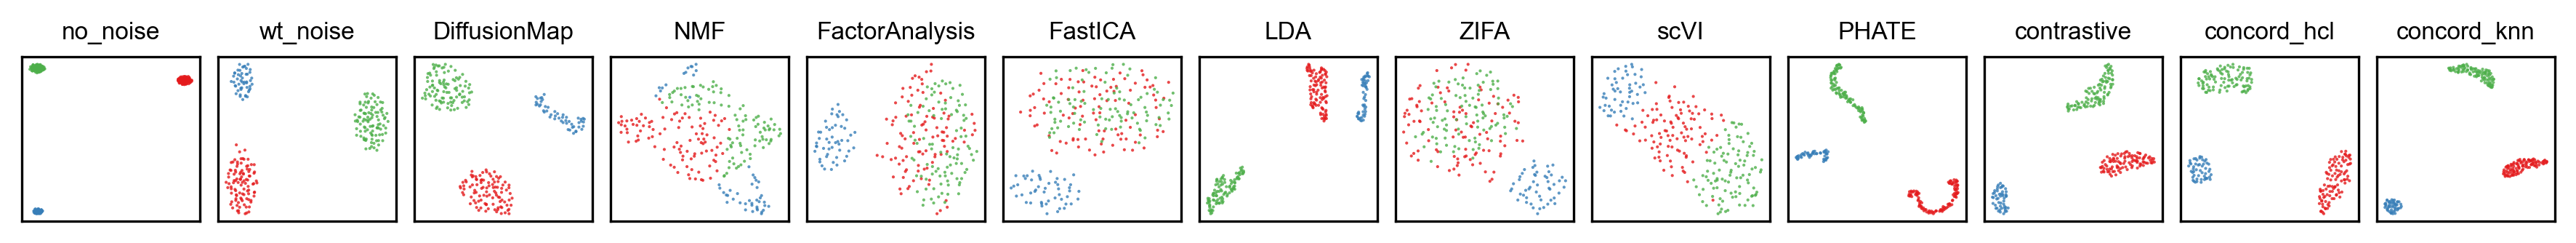

In [25]:
# plot everything
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import font_manager, rcParams

# Set Arial as the default font
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

color_bys = [state_key]
#basis_types = ['', 'PAGA', 'KNN', 'PCA', 'UMAP']
basis_types = ['UMAP']
font_size=8
point_size=4
alpha=0.8
figsize=(0.9*len(combined_keys),1)
ncols = len(combined_keys)
nrows = 1
pal = {'state':'tab10'}
k=15
edges_color='grey'
edges_width=0.05
layout='kk'
threshold = 0.1
node_size_scale=0.1
edge_width_scale=0.1

with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        combined_keys,
        color_bys=color_bys,
        basis_types=basis_types,
        pal=pal,
        k=k,
        edges_color=edges_color,
        edges_width=edges_width,
        layout=layout,
        threshold=threshold,
        node_size_scale=node_size_scale,
        edge_width_scale=edge_width_scale,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        ncols=ncols,
        seed=1,
        leiden_key='leiden',
        save_dir=save_dir,
        file_suffix=file_suffix,
        save_format='svg'
    )


In [18]:
# sort and smooth the signal along the path
batch_id=adata.obs['batch'].unique()[0]
batch_indices = np.where(adata.obs['batch'] == batch_id)[0]
_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='Concord', path=batch_indices, sigma=2)
adata.obsm['Concord_sorted'] = adata.obsm['Concord'][:, feature_order]

_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='Concord-decoder', path=batch_indices, sigma=2)
adata.obsm['Concord-decoder_sorted'] = adata.obsm['Concord-decoder'][:, feature_order]

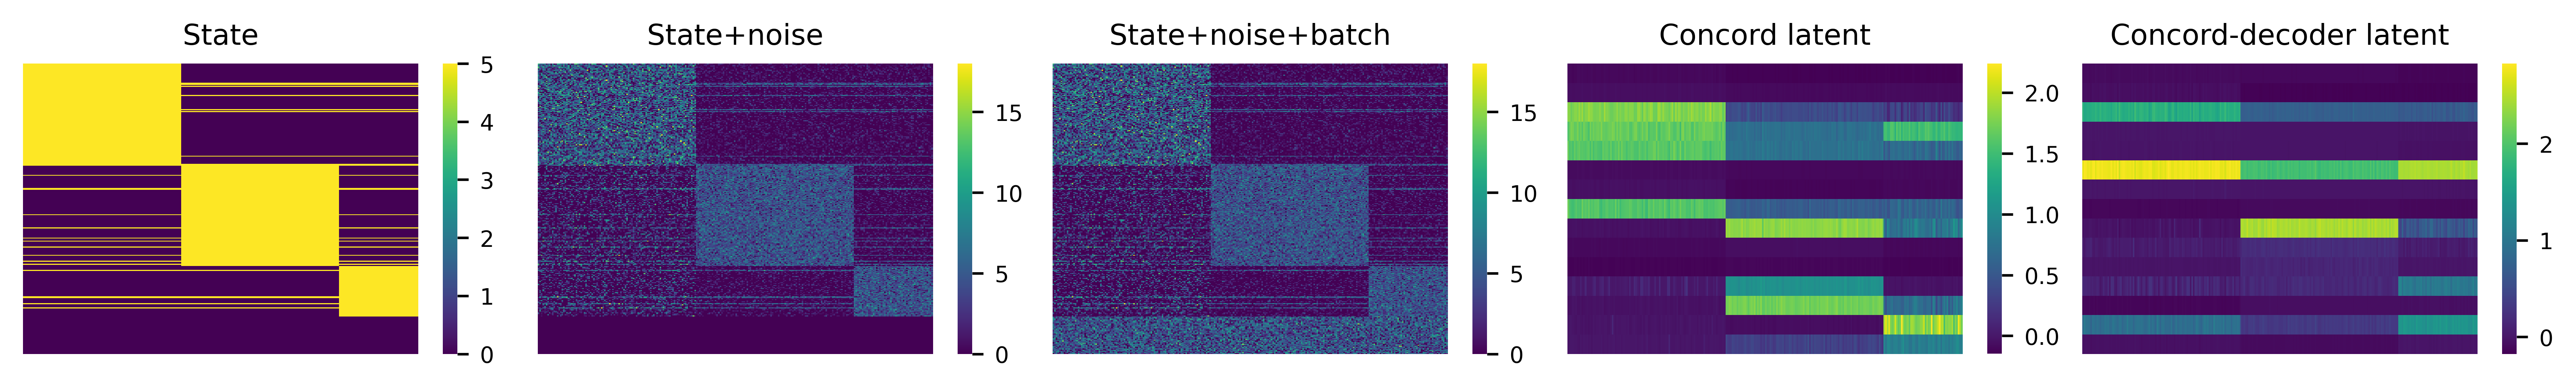

In [19]:
# Plot heatmap of original data and Concord latent
import matplotlib.pyplot as plt
figsize = (2.3, 1.8)
ncols = 5
title_fontsize = 9
dpi = 600
fig, axes = plt.subplots(1, ncols, figsize=(figsize[0] * ncols, figsize[1]), dpi=dpi)
ccd.pl.heatmap_with_annotations(adata, val='no_noise', obs_keys=[state_key], ax = axes[0], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='wt_noise', obs_keys=[state_key], ax = axes[1], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, batch_key], ax = axes[2], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise+batch', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='Concord_sorted', obs_keys=[state_key, batch_key], ax = axes[3], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord latent', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='Concord-decoder_sorted', obs_keys=[state_key, batch_key], ax = axes[4], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord-decoder latent', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
plt.tight_layout(w_pad=0.0, h_pad=0.1)
plt.savefig(save_dir / f"all_heatmaps_{file_suffix}.svg", dpi=dpi, bbox_inches='tight')

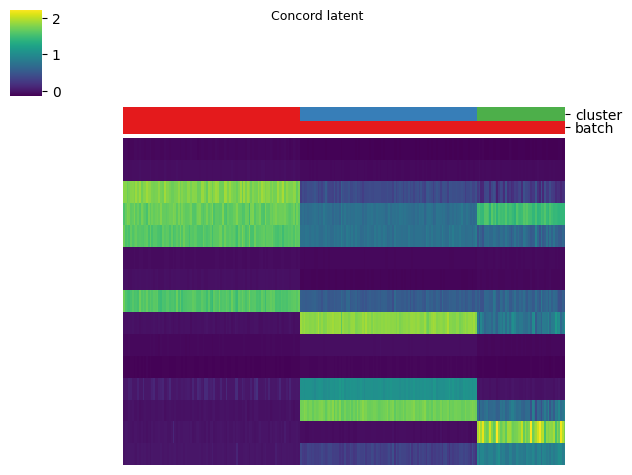

In [20]:
ccd.pl.heatmap_with_annotations(adata, val='Concord_sorted', obs_keys=[state_key, batch_key], ax = axes[3], use_clustermap=True, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord latent', save_path=f"heatmap_wt_annot_{file_suffix}.svg", figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)

In [ ]:
adata.write_h5ad(data_dir / f"adata_{file_suffix}.h5ad")
adata_state.write_h5ad(data_dir / f"adata_state_{file_suffix}.h5ad")
file_suffix

# Evaluation

In [ ]:
adata = sc.read(data_dir / f"adata_Feb06-1037.h5ad")
adata_state = sc.read(data_dir / f"adata_state_Feb06-1037.h5ad")

### Topology

Run topological analysis pipeline:

In [ ]:
run_methods = ["PCA", "UMAP", "t-SNE", "DiffusionMap", "NMF", 
             "FactorAnalysis", "FastICA", "LDA", "ZIFA", "scVI", "PHATE", 
             "Concord", "Concord-decoder"]
# exclude ["UMAP", "t-SNE"] from run_method, and save as combined_keys
exclude_keys = ["PCA", "UMAP", "t-SNE"]
combined_keys_topo = ['no_noise_PCA', 'wt_noise_PCA'] + [key for key in run_methods if key not in exclude_keys]
combined_keys_topo

In [ ]:
homology_dimensions = [0,1,2]
diagrams = {}
for key in combined_keys_topo:
    print(f"Computing persistent homology for {key}")
    diagrams[key] =  ccd.ul.compute_persistent_homology(adata, key=key, homology_dimensions=homology_dimensions)

import pickle
with open(save_dir / f"topology_diagrams_{file_suffix}.pkl", 'wb') as f:
    pickle.dump(diagrams, f)

In [ ]:
save_dir / f"topology_diagrams_{file_suffix}.pkl"

In [ ]:
import pickle
with open(Path('../save/dev_simulation_clustereasy_singlebatch-Feb06/topology_diagrams_Feb06-1037.pkl'), 'rb') as f:
    diagrams = pickle.load(f)

In [ ]:
expected_betti_numbers = [2,0,0]
max_betti = np.max(expected_betti_numbers)
topology_results = ccd.ul.benchmark_topology(diagrams, expected_betti_numbers=expected_betti_numbers, save_dir=save_dir, file_suffix=file_suffix)
topology_metrics = topology_results['combined_metrics']#.drop(index=['no_noise_PCA', 'wt_noise_PCA'])
topology_metrics[('Betti number', 'L1 distance')] = topology_metrics[('Betti number', 'L1 distance')].clip(upper=2 * max_betti)
topology_metrics

In [ ]:
topology_df = topology_metrics.copy()

# Rename row name "no_noise_PCA" to "no_noise", "wt_noise_PCA" to "wt_noise"
topology_df.rename(
    index={
        "no_noise_PCA": "no_noise",
        "wt_noise_PCA": "wt_noise"
    },
    inplace=True
)

topology_df[("Topological metrics", "Betti curve stability")] = topology_df["Betti curve"][
    ["Entropy"]
]
topology_df[("Topological metrics", "Betti number accuracy")] = topology_df["Betti number"][
    ["L1 distance"]
]

topology_df.drop(
    columns=[
        ("Betti curve", "Variance"),
        ("Betti curve", "Entropy"),
        ("Betti number", "L1 distance")
    ],
    inplace=True
)

topology_df


In [ ]:
agg_name1 = ''
agg_name2 = 'Topology Score'
drop_methods = ['Concord-decoder', 'Concord-pknn0']
topology_scores = ccd.ul.benchmark_stats_to_score(topology_df.drop(index=drop_methods), min_max_scale=True, one_minus=True, aggregate_score=False, aggregate_score_name1=None, aggregate_score_name2=None, rank=False, rank_col=None, name_exact=False)
# Weight the metrics
topology_scores[("", "Topology Score")] = topology_scores[("Topological metrics", "Betti curve stability")]*0.2 + topology_scores[("Topological metrics", "Betti number accuracy")]*0.8
topology_scores.sort_values(by=("", "Topology Score"), ascending=False, inplace=True)
topology_scores

In [ ]:
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_benchmark_table(topology_scores, pal='PRGn', pal_agg='RdYlBu_r', cmap_method = 'minmax', agg_name = agg_name1, save_path=save_dir / f"topology_results_{file_suffix}.pdf", figsize=(6, 8), dpi=300)

In [ ]:
# Reorder diagrams with the same order as the combined keys
diagrams_ordered = {key: diagrams[key] for key in combined_keys_topo}
# Change the key names to remove 'PCA_'
diagrams_ordered = {key.replace('_PCA', ''): diagrams_ordered[key] for key in diagrams_ordered}
ccd.pl.plot_persistence_diagrams(diagrams_ordered, base_size=(1.3, 1.5), dpi=300, marker_size=4, n_cols=12, fontsize=10, save_path=save_dir / f"persistence_diagrams_{file_suffix}.svg", legend=False, label_axes=False, axis_ticks=False)

In [ ]:
ccd.pl.plot_betti_curves(diagrams_ordered, nbins=100, base_size=(1.3, 1.5), n_cols=12, fontsize=10, save_path=save_dir / f"betti_curves_{file_suffix}.pdf", dpi=300, legend=False, label_axes=False, axis_ticks=False)

# Geomtric Features 

### Integrated benchmark pipeline

In [ ]:
geometry_metrics = ['cell_distance_corr', 'local_distal_corr', 'trustworthiness', 'state_distance_corr', 'state_dispersion_corr']
dist_metric = 'cosine'
corr_types = ['pearsonr', 'spearmanr', 'kendalltau']
#groundtruth_key = 'wt_noise'
groundtruth_key = 'no_noise'
# Convert state_dispersion to a dict of groundtruth dispersion
#groundtruth_dispersion = {'cluster_' + str(i): state_dispersion[i]**2 for i in range(5)} # convert to variance
geometry_df, geometry_full = ccd.ul.benchmark_geometry(adata, keys=combined_keys, eval_metrics=geometry_metrics, 
                                      dist_metric=dist_metric,
                                      corr_types = corr_types,
                                      groundtruth_key = groundtruth_key,
                                      ground_truth_dispersion_key = 'wt_noise',
                                      #groundtruth_dispersion = groundtruth_dispersion,
                                      state_key = state_key,
                                      batch_key = batch_key,
                                      dispersion_metric='var',
                                      return_type='full',
                                      start_point=0,
                                      end_point=adata.n_obs-1,
                                      pseudotime_k = 30,
                                      truetime_key = 'time',
                                      save_dir=save_dir, 
                                      file_suffix=file_suffix)

In [ ]:
geometry_full['state_dispersion_corr']

In [ ]:
# Simplify the dataframe by computing average for each metric
geometry_df = ccd.ul.simplify_geometry_benchmark_table(geometry_df)
geometry_df = geometry_df.drop(columns=[('Geometric metrics', 'State distance correlation')]) # Redundant with cell distance correlation
geometry_df

In [ ]:
agg_name1 = ''
agg_name2 = 'Geometric Score'
drop_methods = ['Concord-decoder', 'Concord-pknn0']
geometry_scores = ccd.ul.benchmark_stats_to_score(
    geometry_df.drop(index=drop_methods), fillna = 0,               
    min_max_scale=False, one_minus=False, aggregate_score=True, aggregate_score_name1=agg_name1, aggregate_score_name2=agg_name2, rank=True, rank_col=(agg_name1,agg_name2))
geometry_scores


In [ ]:
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_benchmark_table(geometry_scores, pal='PRGn', pal_agg='RdYlBu_r', cmap_method = 'minmax', agg_name = agg_name1, save_path=save_dir / f"geometry_results_noscale_{dist_metric}_{groundtruth_key}_{file_suffix}.pdf", figsize=(8.5, 7), dpi=300)

In [ ]:
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_distance_heatmap(geometry_full['cell_distance_corr']['distance'], n_cols = 12, figsize=(1.1,1.3), cbar=False, dpi=300, save_path=save_dir / f"cell_distance_hmap_{file_suffix}.svg")

In [ ]:
trustworthiness_scores = geometry_full['trustworthiness']['scores']
drop_methods = ['Concord-pknn0', 'Concord-decoder']
# Drop row with column 'Embedding' in drop_methods
trustworthiness_scores = trustworthiness_scores[~trustworthiness_scores['Embedding'].isin(drop_methods)]
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_trustworthiness(trustworthiness_scores, text_shift=2, legend=False, save_path=save_dir / f"trustworthiness_{groundtruth_key}_{file_suffix}.pdf", figsize=(4,3))

In [ ]:
# Drop value with keys in drop_methods from dictionary
import matplotlib.pyplot as plt
dispersion_dict = geometry_full['state_dispersion_corr']['dispersion']
dispersion_dict = {key: dispersion_dict[key] for key in dispersion_dict if key not in drop_methods}
correlation_df = geometry_full['state_dispersion_corr']['correlation'].drop(index=drop_methods)
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_geometry_scatter(
        data_dict = dispersion_dict,
        correlation= correlation_df,
        s=30, c='darkblue',
        ground_key = 'wt_noise',
        linear_fit = True,
        n_cols = 11, figsize=(1.5,1.75), dpi=300, save_path=save_dir / f"state_dispersion_scatter_{groundtruth_key}_{file_suffix}.pdf")

## Combine all metrics

In [ ]:
# Combine all metrics into one table
import pandas as pd
all_scores = pd.concat([topology_scores, geometry_scores], axis=1)
all_scores

In [ ]:
all_scores[('Aggregate score', 'Topology')] = all_scores[('', 'Topology Score')]
all_scores[('Aggregate score', 'Geometry')] = all_scores[('', 'Geometric Score')]
all_scores[('Aggregate score', 'Average Score')] = all_scores["Aggregate score"][["Topology", "Geometry"]].mean(axis=1)
# sort by average score
all_scores.sort_values(by=[('Aggregate score', 'Average Score')], ascending=False, inplace=True)
all_scores.drop(
    columns=[
        ('', 'Topology Score'),
        ('', 'Geometric Score')
    ],
    inplace=True
)
# Save table
all_scores.to_csv(save_dir / f"benchmark_results_{file_suffix}.csv")
all_scores

In [ ]:
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_benchmark_table(all_scores, pal='viridis', pal_agg='viridis', cmap_method = 'minmax', agg_name = 'Aggregate score', save_path=save_dir / f"all_results_{file_suffix}.pdf", figsize=(10, 6.2), dpi=300)